### Import libraries

In [1]:
import os, sys
import random
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from keras import backend as K
from keras.layers import Dropout, Dense, BatchNormalization, Flatten, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet import MobileNet
from keras.models import Sequential
from sklearn.metrics import precision_recall_fscore_support
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
import tensorflow.keras.utils as image
from keras.applications.imagenet_utils import preprocess_input
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report 

In [2]:
train_data_dir = 'X-Ray-Scanner-Dataset'


### Different classes

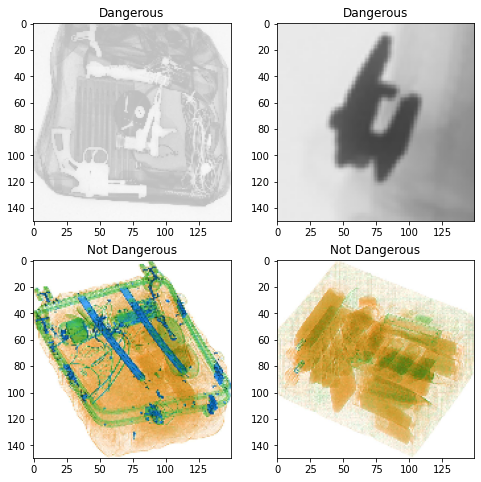

In [3]:
image_per_class = 2
classes = os.listdir(train_data_dir)
subplot = len(classes)*100 + image_per_class*10 + 1
fig = plt.figure(figsize=(8,8))
for each_class in classes:
    files = os.listdir(os.path.join(train_data_dir, each_class))
    files_to_print = random.sample(files, image_per_class)
    for image_file in files_to_print:
        img = image.load_img(os.path.join(train_data_dir, each_class, image_file), target_size=(150,150))
        plt.subplot(subplot)
        plt.imshow(img)
        plt.title(each_class)
        subplot += 1
plt.show()

In [4]:
rescale = 1./255
target_size = (150, 150)
batch_size = 16
class_mode = "categorical"
#class_mode = "binary"

train_datagen = ImageDataGenerator(rescale=rescale,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2) # set validation split

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    train_data_dir, # same directory as training data
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation') # set as validation data


Found 2184 images belonging to 2 classes.
Found 545 images belonging to 2 classes.


In [7]:
# Checkpoint
model_dir = 'models'
model_file = model_dir + '/contra-band-{epoch:02d}.hdf5'
checkpoint = ModelCheckpoint(
    model_file, 
    monitor='acc',
    save_freq=1)

callbacks = [checkpoint]

In [8]:
def get_mobilenet():
    base_mobilenet_model = MobileNet(
        input_shape=(150, 150, 3), 
        include_top=False,
        weights=None
    )
    model = Sequential()
    model.add(base_mobilenet_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.5))
    model.add(Dense(512))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))
    return model

In [9]:
optimizer = Adam(learning_rate=0.001)
# For more than two classes use categorical_crossentropy or sparse_categorical_crossentropy
loss = 'categorical_crossentropy'
metrics = ['accuracy']
steps_per_epoch = 25
validation_steps = 10
epochs = 50

In [10]:
model = get_mobilenet()
model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_150 (Functio  (None, 4, 4, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 1

In [11]:
epochs = 50
history = model.fit(
    train_generator,
    steps_per_epoch = steps_per_epoch,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    epochs=epochs,
    callbacks = callbacks,
  verbose=1)

Epoch 1/50
25/25 [==============================] - 23s 544ms/step - loss: 1.1579 - accuracy: 0.7200 - val_loss: 0.7882 - val_accuracy: 0.5000
Epoch 2/50
25/25 [==============================] - 11s 447ms/step - loss: 0.5483 - accuracy: 0.8550 - val_loss: 1.1440 - val_accuracy: 0.4750
Epoch 3/50
25/25 [==============================] - 12s 456ms/step - loss: 0.3788 - accuracy: 0.8875 - val_loss: 0.9796 - val_accuracy: 0.4625
Epoch 4/50
25/25 [==============================] - 11s 433ms/step - loss: 0.3303 - accuracy: 0.9275 - val_loss: 2.7568 - val_accuracy: 0.5125
Epoch 5/50
25/25 [==============================] - 10s 411ms/step - loss: 0.3799 - accuracy: 0.8825 - val_loss: 2.0447 - val_accuracy: 0.5312
Epoch 6/50
25/25 [==============================] - 11s 443ms/step - loss: 0.1652 - accuracy: 0.9337 - val_loss: 1.6772 - val_accuracy: 0.4875
Epoch 7/50
25/25 [==============================] - 11s 420ms/step - loss: 0.0539 - accuracy: 0.9750 - val_loss: 2.2452 - val_accuracy: 0.5500

In [10]:
from keras.models import load_model

In [11]:
model_epoch = load_model('../models/contra-band-50.hdf5')
model_epoch.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_150 (Functio  (None, 4, 4, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 1

In [12]:
y_pred = model_epoch.predict(validation_generator)
y_pred = y_pred.argmax(axis=-1)
print(y_pred)

35/35 [==============================] - 8s 223ms/step
[1 0 0 1 0 0 0 1 1 1 0 0 1 1 1 1 0 1 0 1 1 1 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0
 0 0 1 0 0 1 1 0 1 1 0 1 1 0 0 0 0 1 0 0 0 0 0 1 1 0 0 1 0 0 1 0 0 0 0 0 1
 1 1 0 1 1 0 1 1 0 1 1 1 0 0 0 0 0 0 0 0 1 1 0 0 1 0 1 0 0 0 0 1 1 0 1 0 0
 1 1 0 1 0 1 1 1 1 0 0 0 1 1 1 0 1 1 0 1 1 1 1 0 0 1 0 1 0 1 1 1 0 0 0 1 1
 1 0 0 1 1 1 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 1 1 0 1 0 0 1 0 0 1 0 1 1
 0 1 0 1 0 0 0 0 1 1 1 0 1 0 1 0 0 1 1 0 1 1 1 0 1 0 0 0 1 1 0 1 0 0 1 0 0
 0 0 0 0 1 1 0 1 1 1 0 0 1 1 0 0 0 0 0 1 1 0 1 0 1 1 1 0 1 1 1 1 0 0 0 0 0
 0 0 0 1 1 0 1 1 1 0 0 0 1 0 1 0 0 0 0 1 1 1 1 1 1 0 1 1 1 1 0 1 0 1 1 0 0
 0 1 0 0 1 1 1 0 0 0 1 0 0 0 0 0 0 1 1 0 1 0 1 1 0 1 0 1 0 0 1 0 1 0 1 1 1
 0 0 1 0 1 1 0 1 0 0 1 1 0 0 1 0 0 1 1 1 1 1 0 0 1 1 0 1 1 0 0 0 1 1 0 1 0
 1 0 0 1 1 0 0 0 1 0 1 0 0 1 1 1 0 0 1 0 0 0 0 0 0 1 0 1 0 0 1 1 0 0 1 0 1
 1 1 0 1 1 0 0 0 0 1 1 1 1 0 0 0 1 1 1 0 0 1 1 1 0 1 1 1 1 1 1 0 1 1 1 0 0
 1 0 1 0 1 0 1 0 1 0 1 0 0 0 0 1 1 1 1 1 0 0 

In [ ]:
y_test = model_epoch.predict

Now, lets validate the model

In [13]:
y_true = validation_generator.classes
y_true = y_true.reshape((y_true.shape[0], 1))
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.55      0.54      0.55       290
           1       0.49      0.51      0.50       255

    accuracy                           0.52       545
   macro avg       0.52      0.52      0.52       545
weighted avg       0.52      0.52      0.52       545



Due to sparsity of data, the performance of the model is bad. To improve this we are trying to gather more data.

In [14]:
labels=[]
for i in y_pred:
    if i==0:
        labels.append('Not Dangerous')
    else:
        labels.append("Dangerous")


In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as finimg

In [ ]:
osdir = "C:/Users/Himadhith/Desktop/mi project/Detect-X-app/X-Ray-Scanner-Dataset/"
for i in validation_generator.filenames:
    i=i.replace("\\",'/')
    image = finimg.imread(osdir+i)
    plt.figure()
    plt.imshow(image)
    print(i)

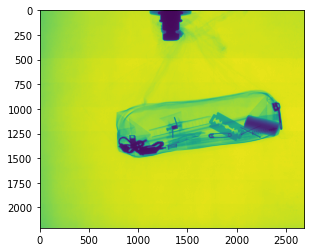

In [3]:
for i in validation_generator.filenames:
    image = finimg.imread(r"i")
    plt.figure()
    plt.imshow(image)